## VehicleDetect

Section 1:  **Train model**
* Prepare data
* Extract features from the data
* Train a model to identify cars and non-cars

Section 2: **Identify**
* Use the model to identify all cars in the image
* Deal with the result by making heat-map.
* Identify the vehicle from the vedio

### Hog function test

/home/cabbage/anaconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


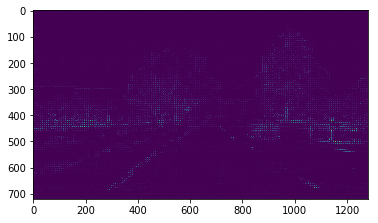

In [1]:
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt

%matplotlib inline
file_name = "test_images/test1.jpg"
img_test = cv2.imread(file_name)

hls = cv2.cvtColor(img_test, cv2.COLOR_BGR2HLS)

features, hog_image = hog(hls[:,:,2], orientations=9, pixels_per_cell = (8, 8),
                          cells_per_block=(2, 2), visualise=True, 
                          feature_vector=False)

plt.imshow(hog_image)

### Helper functions to extract features from image

In [1]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    features = features / 10.0
    return features
 
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
   
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features      

# 返回img片段里的所有feature
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
 
    #9) Return concatenated array of features
    return np.concatenate(img_features)

    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    count = 0
    for file in imgs:
        count += 1
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        resize_img = cv2.resize(image, (64, 64))  
        file_features = single_img_features(resize_img, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                                    orient=orient, pix_per_cell=pix_per_cell, 
                                    cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                    hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(file_features)
    # Return list of feature vectors
    # print('len(featrues):',len(features), 'count:', count, 'len(imgs):', len(imgs))
    return features 

### Prepare Data for training.

In [3]:
import numpy as np
import matplotlib.image as mpimg
import glob

feature_list = []
car_features = []
notcar_features = [] 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, 700] # Min and max in y to search in slide_window()

cars = glob.glob('vehicles/*/*.png')
non_cars = glob.glob('non-vehicles/*/*.png')

print('cars number:',len(cars), 'Non-cars number:',len(non_cars))
# Equal the number of cars and non-cars
if len(cars) < len(non_cars):
    non_cars = non_cars[:len(cars)]
else:
    cars = cars[:len(non_cars)]
print('New cars number:',len(cars), 'New Non-cars number:',len(non_cars))

car_features = extract_features(cars,color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

notcar_features = extract_features(non_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

feature_list.append(car_features + notcar_features)
print(type(feature_list))
X = np.vstack(feature_list).astype(np.float64)
y = np.hstack( (np.ones(len(car_features)), np.zeros(len(notcar_features))) )
print('len(X[0]):',len(X[0]), 'len(X):',len(X), 'len(y):',len(y))

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)



cars number: 9755 Non-cars number: 9613
New cars number: 9613 New Non-cars number: 9613


/home/cabbage/anaconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


<class 'list'>
len(X[0]): 1764 len(X): 19226 len(y): 19226


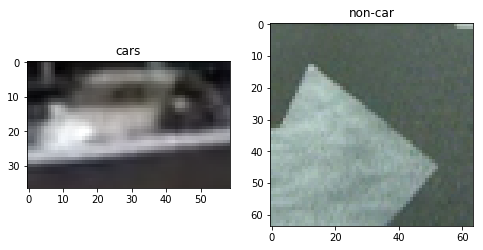

In [4]:
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.set_title('cars')
ax1.imshow(cv2.imread(cars[0]))
ax2.set_title('non-car')
ax2.imshow(cv2.imread(non_cars[0]))

### Train it to identify vehicles and non-vehicles

In [5]:
from sklearn.cross_validation import train_test_split
rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, 
                                                    random_state=rand_state)

#print(y, y_test, y_train)

from sklearn.svm import LinearSVC, SVC
svc = SVC()
svc.fit(X_train, y_train)
print("Test Accuracy of SVC = ", svc.score(X_test, y_test))


/home/cabbage/anaconda2/envs/tensorflow/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Test Accuracy of SVC =  0.989599583983


### Helper function to Slide Windows and match cars

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

      
     
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
# 计算所有Window的坐标
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            #return window_list
    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
 
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
        #return on_windows
    #8) Return windows for positive detections
    return on_windows

### Helper function to deal with heat map

In [7]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    #heatmap[heatmap >= threshold] = 255
    return heatmap

def draw_labeled_bboxes(img, labels):  # Q1
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

### Find the vehicle from the image

/home/cabbage/anaconda2/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


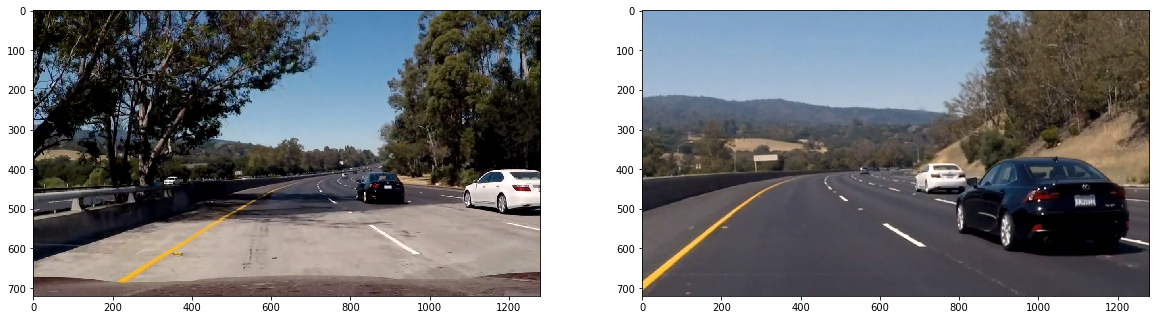

In [8]:
def check_overlap(a, b):
    # vertex a/b has 2 points: [(start_x, start_y). (end_x, end_y)]
    # change it to 4 points.
    a = [ a[0], (a[0][0], a[1][1]), (a[1][0], a[0][1]), a[1] ]
    b = [ b[0], (b[0][0], b[1][1]), (b[1][0], b[0][1]), b[1] ]

    for i in range(2):
        for point_a in a:
            if point_a[0] > b[0][0] and point_a[1] > b[0][1]  and \
               point_a[0] < b[3][0] and point_a[1] < b[3][1]:
                return True
        a, b = b, a

    return False  

class ImageProcess():
    def __init__(self):
        self.frames_windows = []
        self.repeat_count = 60
    def process_image(self, image):
        windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(64, 64), xy_overlap=(0.6, 0.6))
        windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(109, 68), xy_overlap=(0.7, 0.7))
        windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(143, 72), xy_overlap=(0.8, 0.8))        
        windows_4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(220, 100), xy_overlap=(0.8, 0.8))
        windows_5 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                            xy_window=(239, 127), xy_overlap=(0.8, 0.8))    

        windows = windows_1 + windows_2 + windows_3 + windows_4 + windows_5
        hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
        hot__repeat_windows = []
        for window in hot_windows:
            count = 0
            for old_frame in self.frames_windows:
                for old_window in old_frame:
                    if check_overlap(old_window, window) == True:
                        count += 1
                        break
            # 连续N帧检查出来有重叠，才显示。
            if count >= self.repeat_count:
                hot__repeat_windows.append(window)
                        
        if len(self.frames_windows) >= self.repeat_count:
            self.frames_windows.pop()
        self.frames_windows.insert(0, hot_windows)
        #heat map
    #     heat_map = np.zeros_like(image)[:,:,1]
    #     heat_map = add_heat(heat_map, hot_windows)
    #     heat_map = apply_threshold(heat_map, 1)
    #     #plt.imshow(heat_map)
    #     from scipy.ndimage.measurements import label
    #     labels = label(heat_map)
    #     print(labels[1], 'cars found')
    #     plt.imshow(labels[0], cmap='gray')
    #     # draw boxes
    #    draw_img = draw_labeled_bboxes(np.copy(image), labels)
        draw_img = draw_boxes(image, hot__repeat_windows, color=(0, 255, 0), thick=2)   
        return draw_img



image = mpimg.imread('test_images/test5.jpg')
image2 = mpimg.imread('/home/cabbage/Desktop/test.jpg')
f, (ax1,ax2) = plt.subplots(1, 2,figsize=(20,12))
objecta = ImageProcess()
window_img = objecta.process_image(image)
ax1.imshow(window_img)
window_img2 = objecta.process_image(image2)
ax2.imshow(window_img2)

# from scipy.ndimage.measurements import label
# labels = label(heatmap)
# labels = label(heatmap)
# print(labels[1], 'cars found')
# plt.imshow(labels[0], cmap='gray')


#plt.imshow(window_img, cmap='gray')

### Detect  the vehicle in the vedio.

In [9]:
import imageio
from moviepy.editor import VideoFileClip
vehicle_detect_output = "output_images/vehicle_detect_24_48.mp4"
clip_vedio = VideoFileClip("project_video.mp4").subclip(24,48)
detected_clip = clip_vedio.fl_image(objecta.process_image)
%time detected_clip.write_videofile(vehicle_detect_output, audio=False)

[MoviePy] >>>> Building video output_images/vehicle_detect_24_48.mp4
[MoviePy] Writing video output_images/vehicle_detect_24_48.mp4


100%|█████████▉| 600/601 [4:16:24<00:23, 23.62s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/vehicle_detect_24_48.mp4 

CPU times: user 4h 16min 17s, sys: 10.1 s, total: 4h 16min 27s
Wall time: 4h 16min 26s
